# Evaluation of invivo data

In [2]:
import numpy as np
import tensorflow as tf
import time
import h5py
# from Network.PatchHandler3D import PatchHandler3D
from Network.PatchHandler3D_temporal import PatchHandler4D
from test_iterator import check_compatibility, load_indexes
import ipywidgets as widgets
from ipywidgets import HBox, VBox
import matplotlib.pyplot as plt
from IPython.display import display
from utils.evaluate_utils import *
from scipy.ndimage import binary_erosion
from mpl_toolkits.axes_grid1 import make_axes_locatable
from prepare_data.h5functions import save_to_h5
import matplotlib
from utils.colors import *
import matplotlib.animation as animation
plt.rcParams['figure.figsize'] = [10, 8]

### In vivo data visualization

In [8]:
# look at in vivo data
# in_vivo = '../data/PIA/BARCELONA/BARCELONA2/h5/case_000.h5'
# in_vivo_upsampled = '../results/in_vivo/BARCELONA2/case_000_20230508-1433_60Frames.h5' # _newshape
# in_vivo_upsampled = '../results/in_vivo/BARCELONA/Frame60_20230405-1417_temporal_newmask_test2.h5'
in_vivo = '../data/PIA/THORAX/P05/h5/P05.h5'
in_vivo_upsampled = '../results/in_vivo/THORAX/P05_20230508-1433_8_4_arch_25Frames.h5' 
# in_vivo_upsampled = '../results/in_vivo/THORAX/P01_20230405-1417_temporal_mask_magnitude.h5' 

eval_dir = '../results/in_vivo/BARCELONA2/plots'
name_evaluation = f'THORAX_P03_{os.path.basename(in_vivo)[:-3]}'

data_1 = {}
data_predicted = {}
vencs = {}
vel_colnames = ['u', 'v','w']
mag_colnames = ['mag_u', 'mag_v', 'mag_w']
venc_colnames = [  'u_max', 'v_max', 'w_max'] #['venc_u', 'venc_v', 'venc_w']#


# load in-vivo data
with h5py.File(in_vivo, mode = 'r' ) as p1:
    data_1['mask'] =  np.asarray(p1['mask']).squeeze()
    print(p1.keys())
    for vel, venc in zip(vel_colnames, venc_colnames):
        vencs[venc] = np.asarray(p1[venc])
        data_1[vel] = np.asarray(p1[vel], dtype = float).squeeze()#/np.max(vencs[venc]) #TODO change this
        print(vel, data_1[vel].shape)
        data_1[f'{vel}_fluid'] = np.multiply(data_1[vel], data_1['mask'])
    for mag in mag_colnames:
         data_1[mag] =  np.asarray(p1[mag]).squeeze()

# load prediction
with h5py.File(in_vivo_upsampled, mode = 'r' ) as h_pred:
    for vel, venc in zip(vel_colnames, venc_colnames):
        data_predicted[vel] = np.asarray(h_pred[f'{vel}_combined']) #/np.max(vencs[venc]) 
        print(data_predicted[vel].shape)
        # data_predicted[vel] = data_predicted[vel][:data_1[vel].shape[0]] # TODO delete this, tis is just because it overwrote the file
        # add information considering only the fluid regions  
        if data_predicted[vel].shape[0] == data_1[vel].shape[0]:
            data_predicted[f'{vel}_fluid'] = np.multiply(data_predicted[vel], data_1['mask'])
            data_predicted['mask'] = data_1['mask']
            
        elif  data_predicted[vel].shape[0] == 2*data_1[vel].shape[0]:
            t, x, y, z = data_1['mask'].shape
            data_predicted['mask']= np.zeros((2*t,x, y, z ))
            data_predicted['mask'][::2, :, :, :] = data_1['mask']
            data_predicted['mask'][1::2, :, :, :] = data_1['mask']
            data_predicted[f'{vel}_fluid'] = np.multiply(data_predicted[vel], data_predicted['mask'])

print('Shape of predicted data and original data:', data_predicted['u'].shape, data_1['u'].shape)
N_frames = data_1['u'].shape[0]
print("Max val:", np.max(data_1['u']), np.max(data_1['v']), np.max(data_1['w']))
print("Min val:", np.min(data_1['u']), np.min(data_1['v']), np.min(data_1['w']))


#find lower and higher values to display velocity fields
min_v = {}
max_v = {}
for vel in vel_colnames:
    min_v[vel] = np.quantile(data_1[vel][np.where(data_1['mask'] !=0)].flatten(), 0.01)
    max_v[vel] = np.quantile(data_1[vel][np.where(data_1['mask'] !=0)].flatten(), 0.99)
    print(min_v[vel], max_v[vel])

magn = np.sqrt(data_1['mag_u']**2 + data_1['mag_v']**2 + data_1['mag_w']**2)
speed = np.sqrt(data_1['u']**2 + data_1['v']**2 + data_1['w']**2)
pc_mri = np.multiply(magn, speed)
data_1['mean_speed'] = calculate_mean_speed(data_1["u_fluid"], data_1["v_fluid"] , data_1["w_fluid"], data_1["mask"])
data_predicted['mean_speed'] = calculate_mean_speed(data_predicted["u_fluid"], data_predicted["v_fluid"] , data_predicted["w_fluid"], data_predicted["mask"])

<KeysViewHDF5 ['dx', 'mag_u', 'mag_v', 'mag_w', 'mask', 'u', 'u_max', 'v', 'v_max', 'w', 'w_max']>
u (25, 40, 108, 160)
v (25, 40, 108, 160)
w (25, 40, 108, 160)
(25, 40, 108, 160)
(25, 40, 108, 160)
(25, 40, 108, 160)
Shape of predicted data and original data: (25, 40, 108, 160) (25, 40, 108, 160)
Max val: 1.75 1.7491455078125 1.7491455078125
Min val: -1.7491455078125 -1.75 -1.75
-0.8280029296875 0.6707763671875
-0.435791015625 0.575927734375
-0.5118408203125 0.5810546875


### SNR

Text(0.5, 1.0, 'SNR inside fluid region')

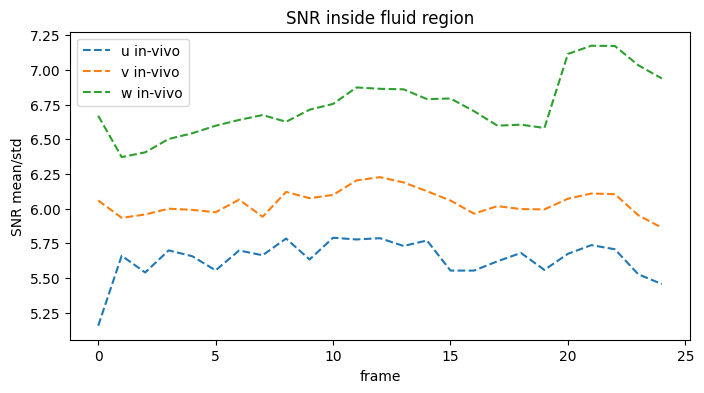

In [4]:
frame_i = 10
u1_i_fluid = data_1['u'][frame_i][np.where(data_1['mask'][frame_i] ==1)]
u2_i_fluid = data_predicted['u'][frame_i][np.where(data_1['mask'][frame_i] ==1)]

mask_SNR = data_1['mask'].copy()
mask_SNR[np.where(data_1['mask'] == 1)] = 2
mask_SNR[:, :, 10:30, 10:-10] = 1
# mask_SNR[np.where(data_1['mag_u'] == 0)] = 1

snr_u_input = [signaltonoise_fluid_region(data_1['u'][frame],mask_SNR[frame]) for frame in range(N_frames)]
snr_v_input = [signaltonoise_fluid_region(data_1['v'][frame],mask_SNR[frame]) for frame in range(N_frames)]
snr_w_input = [signaltonoise_fluid_region(data_1['w'][frame],mask_SNR[frame]) for frame in range(N_frames)]
snr_u_sr =    [signaltonoise_fluid_region(data_predicted['u'][frame], mask_SNR[frame]) for frame in range(N_frames)]
snr_v_sr =    [signaltonoise_fluid_region(data_predicted['v'][frame], mask_SNR[frame]) for frame in range(N_frames)]
snr_w_sr =    [signaltonoise_fluid_region(data_predicted['w'][frame], mask_SNR[frame]) for frame in range(N_frames)]
plt.figure(figsize=(8, 4))
plt.plot(snr_u_input,'--', label= 'u in-vivo')
plt.plot(snr_v_input,'--', label= 'v in-vivo')
plt.plot(snr_w_input,'--', label= 'w in-vivo')
# plt.plot(snr_u_sr, label= 'u predicted')
# plt.plot(snr_v_sr, label= 'v predicted')
# plt.plot(snr_w_sr, label= 'w predicted')
plt.legend()
plt.xlabel('frame')
plt.ylabel('SNR mean/std')
plt.title('SNR inside fluid region')

### Error

In [5]:
error_pointwise, error_absolut = calculate_pointwise_error(data_predicted["u"], data_predicted["v"], data_predicted["w"], data_1["u"], data_1["v"] , data_1["w"], data_1["mask"])

In [6]:


# interpolate data (take every second slice and interpolate them)
# interpolate_linear = {}
# interpolate_cubic = {}
# for vel in vel_colnames:
#     interpolate_linear[vel] = temporal_linear_interpolation_np(data_1[vel][::2], data_1[vel].shape)
#     interpolate_linear[f'{vel}_fluid'] = np.multiply(interpolate_linear[vel], data_1['mask'])

    # interpolate_cubic[vel] = temporal_cubic_interpolation(data_1[vel][::2], data_1[vel].shape)
    # interpolate_cubic[f'{vel}_fluid'] = np.multiply(interpolate_cubic[vel], data_1['mask'])

In [9]:

print(data_1.keys())
@widgets.interact(frame=(0, data_predicted['u'].shape[0]-1), x = (0, data_predicted['u'].shape[1]-1))
def f(frame=5, x = 0):
    frame_lr = frame
    if data_predicted['u'].shape[0] == data_1['u'].shape[0]*2:
        frame_lr = frame//2

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 4, 1)
    plt.imshow(data_1['u'][frame_lr, x, :, :], vmin=min_v['u'],  vmax = max_v['u'])
    plt.title(r'Data, $V_x$')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(data_predicted['u'][frame, x, :, :], vmin=min_v['u'],  vmax = max_v['u'])
    plt.title(r'Predicted, $V_x$')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(magn[frame_lr, x, :, :]*data_1['mask'][frame_lr, x, :, :], cmap ='Greys')#,vmin=min_v['u'], vmax = max_v['u'])
    plt.title('magnitude x mask')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(np.multiply(data_1['mask'], data_predicted['u']-data_1['u'])[frame, x, :, :])
    plt.title('Diff in mask')
    plt.axis('off')

    # plt.subplot(1, 4, 4)
    # plt.imshow(mask_SNR[frame, x, :, :], vmin = 0, vmax = 1)#,vmin=min_v['u'], vmax = max_v['u'])
    # plt.title('mask')
    # plt.axis('off')
    # plt.show()



dict_keys(['mask', 'u', 'u_fluid', 'v', 'v_fluid', 'w', 'w_fluid', 'mag_u', 'mag_v', 'mag_w', 'mean_speed'])


interactive(children=(IntSlider(value=5, description='frame', max=24), IntSlider(value=0, description='x', max…

#### Show comparison of prediction and original data

In [ ]:
@widgets.interact(frame=(0, data_1['u'].shape[0]-1), x = (0, data_1['u'].shape[1]-1))
def f(frame=5, x = 0):
    idx_slice = np.index_exp[frame, x, :, :]

    plt.subplot(3, 4, 1)
    # plt.imshow(data_1['u'][idx_slice], vmin = min_v['u'], vmax = max_v['u'])
    plt.imshow(data_1['u_fluid'][idx_slice], vmin = min_v['u'], vmax = max_v['u'])
    plt.title(r'$V_x$')
    plt.axis('off')

    plt.subplot(3, 4, 2)
    # plt.imshow(data_1['v'][idx_slice], vmin = min_v['v'], vmax = max_v['v'])
    plt.imshow(data_1['v_fluid'][idx_slice], vmin = min_v['v'], vmax = max_v['v'])
    plt.title(r'$V_y$')
    plt.axis('off')

    plt.subplot(3, 4, 3)
    # plt.imshow(data_1['w'][idx_slice], vmin = min_v['w'], vmax = max_v['w'])
    plt.imshow(data_1['w_fluid'][idx_slice], vmin = min_v['w'], vmax = max_v['w'])
    plt.title(r'$V_z$')
    plt.axis('off')

    plt.subplot(3, 4, 4)
    plt.imshow(data_1['mask'][idx_slice], cmap ='Greys_r')
    plt.title('mask')
    plt.axis('off')
    
    plt.subplot(3, 4, 5)
    plt.imshow(data_predicted['u'][idx_slice], vmin = min_v['u'], vmax = max_v['u'])
    plt.title(r'$V_x$ predicted')
    plt.axis('off')

    plt.subplot(3, 4, 6)
    plt.imshow(data_predicted['v'][idx_slice], vmin = min_v['v'], vmax = max_v['v'])
    plt.title(r'$V_y$ predicted')
    plt.axis('off')

    plt.subplot(3, 4, 7)
    plt.imshow(data_predicted['w'][idx_slice], vmin = min_v['w'], vmax = max_v['w'])
    plt.title(r'$V_z$ predicted')
    plt.axis('off')

    plt.subplot(3, 4, 8)
    plt.imshow(magn[idx_slice], cmap ='Greys_r')
    plt.title('magnitude')
    plt.axis('off')

    plt.subplot(3, 4, 9)
    plt.imshow(np.abs(data_1['u_fluid'][idx_slice]- data_predicted['u_fluid'][idx_slice]), vmin = min_v['u'], vmax = max_v['u'], cmap = 'coolwarm')
    plt.title('abs diff u, fluid region')
    plt.axis('off')

    plt.subplot(3, 4, 10)
    plt.imshow(np.abs(data_1['v_fluid'][idx_slice] - data_predicted['v_fluid'][idx_slice]), vmin = min_v['v'], vmax = max_v['v'], cmap = 'coolwarm')
    plt.title('abs diff v, fluid region')
    plt.axis('off')

    plt.subplot(3, 4, 11)
    plt.imshow(np.abs(data_1['w_fluid'][idx_slice] -data_predicted['w_fluid'][idx_slice]), vmin = min_v['w'], vmax = max_v['w'], cmap = 'coolwarm')
    plt.title('abs diff w, fluid region')
    plt.axis('off')

    plt.subplot(3, 4, 12)
    plt.imshow(error_pointwise[idx_slice], cmap = 'coolwarm')
    plt.title('relative error')
    plt.axis('off')


    plt.tight_layout()


    plt.show()

#### Show relative error of prediction

In [ ]:
#calculate relative error
# rel_error = calculate_relative_error_normalized(data_predicted["u"][::2], data_predicted["v"][::2], data_predicted["w"][::2], data_1["u"], data_1["v"] , data_1["w"], data_1["mask"])

In [ ]:

# rel_error_lin_interpolation =   calculate_relative_error_normalized(interpolate_linear["u"], interpolate_linear["v"], interpolate_linear["w"], data_1["u"], data_1["v"] , data_1["w"], data_1["mask"])



# interpolate_linear['mean_speed'] = calculate_mean_speed(interpolate_linear["u_fluid"], interpolate_linear["v_fluid"] ,interpolate_linear["w_fluid"], data_1["mask"])

plt.figure(figsize=(8, 5))
plt.subplot(2, 1, 1)
frames = len(rel_error)
plt.title("Relative error")
plt.plot(rel_error, label = name_evaluation)
# plt.plot(rel_error_lin_interpolation[:-1], label = 'linear interpolation',color = 'yellowgreen')
# plt.plot(rel_error_cubic_interpolation, label = 'cubic interpolation', color = 'forestgreen')
plt.plot(50*np.ones(len(rel_error)), 'k:')
plt.xlabel("Frame")
plt.ylabel("Relative error (%)")

plt.ylim((0, 100))
plt.legend()

#max speed 2226 mm/s , i.e. 222 cm/ sec
norm_factor = 1#10**(-3)
norm_fac_u = np.max(vencs['u_max'])
norm_fac_v = np.max(vencs['v_max'])
norm_fac_w = np.max(vencs['w_max'])
plt.subplot(2, 1, 2)
print(norm_factor)
#speed mm/s * 100 *1/100 *1/10
data_1['speed'] = np.sqrt((data_1['u']*norm_fac_u)**2+ (data_1['v']*norm_fac_v)**2+ (data_1['w']*norm_fac_w)**2)
print('max speed:', np.max(data_1['speed']))
frame_range_input = np.linspace(0, data_1['u'].shape[0], data_1['u'].shape[0])
frame_range_predicted = np.linspace(0, data_1['u'].shape[0], data_predicted['u'].shape[0])
plt.title('Mean speed')
plt.plot(frame_range_predicted, calculate_mean_speed(data_predicted["u_fluid"]*norm_fac_u, data_predicted["v_fluid"]*norm_fac_v, data_predicted["w_fluid"]*norm_fac_w,data_predicted["mask"])*norm_factor, label = 'predicted', color= 'steelblue')
plt.plot(frame_range_input, calculate_mean_speed(data_1["u_fluid"]*norm_fac_u, data_1["v_fluid"]*norm_fac_v, data_1["w_fluid"]*norm_fac_w,data_1["mask"])*norm_factor,'--', label = 'data', color= 'black')
plt.xlabel("Frame")
plt.ylabel("Mean speed (cm/s)")
plt.legend()
plt.tight_layout()
plt.savefig(f'{eval_dir}/rel_error_meanspeed_{name_evaluation}.svg')
plt.show()

### mean speed

In [ ]:
plt.figure(figsize=(7, 4))
N_frames_input_data = data_1['u'].shape[0]
N_frames_pred_data = data_predicted['u'].shape[0]

frame_range_input = np.arange(0, N_frames_input_data)#np.linspace(0, data_1['u'].shape[0]-1,  data_1['u'].shape[0])
frame_range_predicted = np.arange(0, N_frames_input_data, 0.5)#np.linspace(0, data_1['u'].shape[0], data_predicted['u'].shape[0])
print(frame_range_input, frame_range_predicted)
plt.title('Mean speed')
plt.plot(frame_range_predicted, data_predicted['mean_speed'], '.-', label = 'prediction', color= KTH_colors['blue100'])
plt.plot(frame_range_input, data_1['mean_speed'],'--', label = 'noisy input data', color= 'black')
plt.plot(frame_range_input, data_1['mean_speed'],'.',  label ='sample points',  color= 'black')
plt.xlabel("Frame")
plt.ylabel("Mean speed (cm/s)")
plt.legend()
plt.tight_layout()
plt.savefig(f'{eval_dir}/Meanspeed_{name_evaluation}.svg')
plt.show()

In [ ]:
print(np.arange(30))
print(np.arange(30)[::2])

### correlation plot

In [ ]:
#get boundary points
peak_flow_frame = np.argmax(data_1['mean_speed'])
bounds, core_mask = get_boundaries(data_1['mask'])
frame_corr_plot = peak_flow_frame.copy()
if frame_corr_plot % 2 == 0: frame_corr_plot +=1 # take next frame if peak flow frame included in lr data
plt.figure(figsize=(15, 5))
plot_correlation(data_1, data_predicted, bounds=bounds, frame_idx=frame_corr_plot, save_as=f'{eval_dir}/Correlation_frame{frame_corr_plot}_{name_evaluation}.pdf')

In [ ]:
vel_plotname = [r'$V_x$', r'$V_y$', r'$V_z$']


print('Peak flow frame:', peak_flow_frame)
frames = data_1['mean_speed'].shape[0]
k = np.zeros(3*frames)
r2 = np.zeros(3*frames)
k_bounds = np.zeros(3*frames)
r2_bounds = np.zeros(3*frames)
bounds_mask = bounds.copy()
inner_mask = data_1['mask'] - bounds_mask

#calculate k values in core and boundary region
for i, vel in enumerate(vel_colnames):
    for t in range(frames):
        k[t+i*frames], r2[t+i*frames]  = calculate_k_R2( data_predicted[vel][t], data_1[vel][t], core_mask[t])
        k_bounds[t+i*frames], r2_bounds[t+i*frames]  = calculate_k_R2( data_predicted[vel][t], data_1[vel][t], bounds[t])

min_val = np.minimum(0.05, np.minimum(np.min(k_bounds), np.min(r2_bounds)))
max_val = np.maximum(np.max(k), np.max(r2))
#make subplots
for i, (vel, title) in enumerate(zip(vel_colnames, vel_plotname)):
    plt.subplot(2, 3, i+1)
    plt.plot(range(frames), k[i*frames:i*frames+frames] , label = 'k core', color = 'black')
    plt.plot(range(frames), k_bounds[i*frames:i*frames+frames] ,'--',  label = 'k boundary', color = KTH_colors['pink100'])
    plt.plot(np.ones(frames), 'k:')
    plt.ylim([min_val, np.maximum(max_val, 1.05)])
    plt.title(title)
    plt.xlabel('frames')
    plt.ylabel('k')
    plt.scatter(np.ones(2)*peak_flow_frame, [k[i*frames+peak_flow_frame],k_bounds[i*frames+peak_flow_frame]] , label = 'peak flow frame', color = KTH_colors['blue80'])
    plt.legend()
for i, (vel, title) in enumerate(zip(vel_colnames, vel_plotname)):
    plt.subplot(2, 3, i+4)
    plt.plot(range(frames), r2[i*frames:i*frames+frames] ,label = r'$R^2$ core', color = 'black')
    plt.plot(range(frames), r2_bounds[i*frames:i*frames+frames] ,'--', label = r'$R^2$ boundary', color = KTH_colors['pink100'])
    plt.plot(np.ones(frames), 'k:')
    plt.ylim([min_val, np.maximum(max_val, 1.05)])
    plt.title(title)
    plt.xlabel('frames')
    plt.ylabel(r'$R^2$')
    plt.scatter(np.ones(2)*peak_flow_frame, [r2[i*frames+peak_flow_frame], r2_bounds[i*frames+peak_flow_frame]] , label = 'peak flow frame', color = KTH_colors['blue80'])
    plt.legend()

plt.tight_layout()
plt.savefig(f'{eval_dir}/k_vals_{name_evaluation}.svg')

#save each plot separately
plt.figure(figsize=(5, 5))
for i, (vel, title) in enumerate(zip(vel_colnames, vel_plotname)):
    plt.clf()
    plt.plot(range(frames), k[i*frames:i*frames+frames] , label = 'k core', color = 'black')
    plt.plot(range(frames), k_bounds[i*frames:i*frames+frames] ,'--',  label = 'k boundary', color = KTH_colors['pink100'])
    plt.plot(np.ones(frames), 'k:')
    plt.ylim([min_val, np.maximum(max_val, 1.05)])
    plt.title(title)
    plt.xlabel('frames')
    plt.ylabel('k')
    plt.scatter(np.ones(2)*peak_flow_frame, [k[i*frames+peak_flow_frame],k_bounds[i*frames+peak_flow_frame]] , label = 'peak flow frame', color = KTH_colors['blue80'])
    plt.legend()
    plt.savefig(f'{eval_dir}/k_vals_{vel}_{name_evaluation}_.svg', bbox_inches='tight')
for i, (vel, title) in enumerate(zip(vel_colnames, vel_plotname)):
    plt.clf()
    plt.plot(range(frames), r2[i*frames:i*frames+frames] ,label = r'$R^2$ core', color = 'black')
    plt.plot(range(frames), r2_bounds[i*frames:i*frames+frames] ,'--', label = r'$R^2$ boundary', color = KTH_colors['pink100'])
    plt.plot(np.ones(frames), 'k:')
    plt.ylim([min_val, np.maximum(max_val, 1.05)])
    plt.title(title)
    plt.xlabel('frames')
    plt.ylabel(r'$R^2$')
    plt.scatter(np.ones(2)*peak_flow_frame, [r2[i*frames+peak_flow_frame], r2_bounds[i*frames+peak_flow_frame]] , label = 'peak flow frame', color = KTH_colors['blue80'])
    plt.legend()
    plt.savefig(f'{eval_dir}/R2_vals_{vel}_{name_evaluation}_.svg', bbox_inches='tight')




## others

In [ ]:


@widgets.interact(frame=(0, data_1['u'].shape[0]-1), x = (0, data_1['u'].shape[1]-1))
def f(frame=5, x = 0):
    plt.subplot(1, 2, 1)
    plt.imshow(data_1['u'][frame, x, :, :], vmin=min_v['u'],  vmax = max_v['u'])
    plt.title('Noisy')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(data_predicted['u'][frame//2, x, :, :],vmin=min_v['u'], vmax = max_v['u'])
    plt.title('Predicted')
    plt.axis('off')
    plt.show()

### Compare input of in-vivo and crop to fluid region

In [ ]:
my_P01 = '../data/PIA/THORAX/P01/h5/P01.h5'
LA_P01 = '../data/PIA/THORAX/P01/h5LeonAdam/P01.h5'

output_filename = '../data/PIA/THORAX/P01/h5/P01_cropped.h5'

print("Testing thorax datset")
def crop_4D_data(data, mask, colnames = ['u', 'v', 'w', 'mag_u', 'mag_v', 'mag_w', 'mask']):
    cropped_data = {}
    print(mask.shape)
    if len(mask.squeeze().shape) == 4: 
        mask3D = np.sum(mask, axis = 0) # sum up to largest mask
        mask3D[np.where(mask3D> 0)] = 1
    rmin, rmax, cmin, cmax, zmin, zmax = bbox2_3D(mask3D)
    
    print('crop vals', rmin, rmax, cmin, cmax, zmin, zmax)
    for value in colnames:
        print("shape before:", data[value].shape)
        cropped_data[value] = np.array(data[value])[:, rmin:rmax, cmin-10:cmax+10, zmin-10:zmax+10]
        print("shape after:", cropped_data[value].shape)
        # save_to_h5(output_filename, value, cropped_data[value], expand_dims=False)

    # save_to_h5(output_filename, "u_max", data['u_max'])
    # save_to_h5(output_filename, "v_max", data['v_max'])
    # save_to_h5(output_filename, "w_max", data['w_max'])

    return cropped_data

def bbox2_3D(img):
    ''' code copied from https://stackoverflow.com/questions/31400769/bounding-box-of-numpy-array'''

    r = np.any(img, axis=(1, 2))
    c = np.any(img, axis=(0, 2))
    z = np.any(img, axis=(0, 1))

    rmin, rmax = np.where(r)[0][[0, -1]]
    cmin, cmax = np.where(c)[0][[0, -1]]
    zmin, zmax = np.where(z)[0][[0, -1]]

    return rmin, rmax, cmin, cmax, zmin, zmax


# with h5py.File(my_P01, mode = 'r' ) as p1:
#     with h5py.File(LA_P01, mode = 'r' ) as p2:
#         print(p1.keys())
#         # for key in p1.keys():
#             # print(key, 'norm of diff', np.linalg.norm(np.array(p1[key]) - np.array(p2[key])))
#             # print(key, 'min', np.min(np.array(p1[key])), np.min(np.array(p2[key])))
#             # print(key,' max', np.max(np.array(p1[key])), np.max(np.array(p2[key])))
#         new_data = crop_4D_data(p1, np.array(p1['mask']))
        
#         # print('venc u', np.unique(np.array(p1['u_max'])), np.unique(np.array(p2['u_max'])) )
#         # print('venc v', np.unique(np.array(p1['v_max'])), np.unique(np.array(p2['v_max'])) )
#         # print('venc w', np.unique(np.array(p1['w_max'])), np.unique(np.array(p2['w_max'])) )

# print(new_data.keys())
# @widgets.interact(frame=(0, new_data['u'].shape[0]-1), x = (0, new_data['u'].shape[1]-1))
# def f(frame=5, x = 0):
#     slice_idx = np.index_exp[frame, x, :, :]
#     plt.figure(figsize=(10, 10))
#     plt.subplot(1, 3, 1)
#     plt.imshow(new_data['u'][slice_idx], vmin=min_v['u'],  vmax = max_v['u'])
#     plt.title('Data, u')
#     plt.axis('off')

#     plt.subplot(1, 3, 2)
#     plt.imshow(new_data['mask'][slice_idx])
#     plt.title('mask')
#     plt.axis('off')

#     plt.subplot(1, 3, 3)
#     plt.imshow(new_data['mag_u'][slice_idx])
#     plt.title('mag, u')
#     plt.axis('off')

# shape before: (25, 48, 108, 160)
# shape after: (25, 42, 44, 59)
# shape after: (25, 42, 64, 79)

### Create temporal gif

In [ ]:
def create_temporal_comparison_gif_plt(spatial_idx, lr, hr, pred, min_v, max_v, title = '', vel = ''):
    N = 3
    N_frames = pred.shape[0]
    print('Number of frames:', N_frames)
    v_lr = lr.copy()
    v_hr = hr.copy()
    v_pred = pred.copy()
    v_NN = temporal_NN_interpolation(v_lr,v_hr.shape )

    # err_max = np.quantile(v_error_abs[np.where(temporal_mask !=0)].flatten(), 0.999)

    fig = plt.figure(frameon=False)
    

    plt.subplot(1, N, 1)
    im1 = plt.imshow(v_NN[0, spatial_idx[0], spatial_idx[1], spatial_idx[2]],vmin=min_v, vmax=max_v)
    plt.axis('off')
    plt.subplot(1, N, 2)
    im2 = plt.imshow(v_hr[0, spatial_idx[0], spatial_idx[1], spatial_idx[2]],vmin=min_v, vmax=max_v)
    plt.axis('off')
    plt.subplot(1, N, 3)
    im3 = plt.imshow(v_pred[0, spatial_idx[0], spatial_idx[1], spatial_idx[2]],vmin=min_v, vmax=max_v)
    plt.axis('off')

    # plt.subplot(1, N, 4)
    # ax = plt.gca()
    # im4 = ax.imshow(v_error_abs[0, idx, :, :],vmin=0, vmax=err_max)
    # plt.axis('off')
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("right", size="5%", pad=0.05)
    # plt.colorbar(im4, cax=cax)
    plt.tight_layout()

    #initialization function: plot the background of each frame
    def init():
        im1.set_data(np.random.random((5,5)))
        im2.set_data(np.random.random((5,5)))
        im3.set_data(np.random.random((5,5)))
        # im4.set_data(np.random.random((5,5)))
        return [im1, im2, im3]#, im4]

    # animation function.  This is called sequentially
    def animate(i):
        im1.set_array(v_NN[i//2, spatial_idx[0], spatial_idx[1], spatial_idx[2]])
        im2.set_array(v_hr[i//2, spatial_idx[0], spatial_idx[1], spatial_idx[2]])
        im3.set_array(v_pred[i, spatial_idx[0], spatial_idx[1], spatial_idx[2]])
        # im4.set_array(v_error_abs[i, idx, :, :])
        
        return [im1, im2, im3]#, im4]

    anim = animation.FuncAnimation(fig,animate, init_func=init,
                                frames = N_frames,
                                interval = 100) # in ms)
    print("Gif is saved under:" f'../results/in_vivo/Animate_invivo_{title}_{vel}_Slower.gif')
    anim.save(f'{eval_dir}/Animate_invivo_{title}_{vel}_Slower_comparison.gif', fps=5)



def create_temporal_comparison_gif_single(spatial_idx, data,  min_v, max_v, title, colormap = 'viridis'):

    print(title, 'nframes:', data.shape[0])
    fig = plt.figure(frameon=False)
    im1 = plt.imshow(data[0, spatial_idx[0], spatial_idx[1], spatial_idx[2]],interpolation='none', vmin=min_v, vmax=max_v, cmap = colormap)
    # plt.title(title)
    plt.axis('off')
    
    #fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    plt.tight_layout()

    #initialization function: plot the background of each frame
    def init():
        im1.set_data(np.random.random((5,5)))
        return [im1]

    # animation function.  This is called sequentially
    def animate(i):
        im1.set_array(data[i, spatial_idx[0], spatial_idx[1], spatial_idx[2]])
        return [im1]

    anim = animation.FuncAnimation(fig,animate, init_func=init,
                                frames = data.shape[0],
                                interval = 100, repeat = False) # in ms)
    anim.save(f'{eval_dir}/Animate_invivo_{title}_Slower.gif', fps=10)

# gif_data_original = crop_4D_data(data_1, data_1['mask'], colnames=['u', 'v', 'w', 'mask'])
# gif_data_predicted = crop_4D_data(data_predicted, data_1['mask'], colnames=['u', 'v', 'w'])
# # gif_data_predicted = {}
# gif_data_original_fluid = {}

# # rmin, rmax, cmin, cmax, zmin, zmax = bbox2_3D(data_1['mask'])
# for vel in vel_colnames:
#     # gif_data_predicted[vel] = np.array(data_predicted[vel])[:, rmin:rmax, cmin-10:cmax+10, zmin-10:zmax+10]
#     print(gif_data_predicted[vel].shape)
#     gif_data_original_fluid[f'{vel}_fluid'] = np.multiply(gif_data_original[vel], gif_data_original['mask'])

idx_slice = np.index_exp[19, :, :]

# create_temporal_comparison_gif_single(idx_slice, gif_data_original['v'],'v' , "HR")     
# create_temporal_comparison_gif_single(idx_slice, gif_data_predicted['v'],'v' , "Predicted")         

# create_temporal_comparison_gif_plt(idx_slice, gif_data_original['u'], gif_data_original_fluid['u_fluid'], gif_data_predicted['u'],  min_v['u'], max_v['u'], title = 'BARCELONA_u')
# create_temporal_comparison_gif_plt(idx_slice, gif_data_original['v'], gif_data_original_fluid['v_fluid'], gif_data_predicted['v'],  min_v['v'], max_v['v'], title = 'BARCELONA_v')
# create_temporal_comparison_gif_plt(idx_slice, gif_data_original['w'], gif_data_original_fluid['w_fluid'], gif_data_predicted['w'],  min_v['w'], max_v['w'], title = 'BARCELONA_w')


# create_temporal_comparison_gif_plt(idx_slice, data_1['u'], data_1['u_fluid'], data_predicted['u'],  min_v['u'], max_v['u'], title = f'{name_evaluation}_u')
# create_temporal_comparison_gif_plt(idx_slice, data_1['v'], data_1['v_fluid'], data_predicted['v'],  min_v['v'], max_v['v'], title = f'{name_evaluation}_v')
# create_temporal_comparison_gif_plt(idx_slice, data_1['w'], data_1['w_fluid'], data_predicted['w'],  min_v['w'], max_v['w'], title = f'{name_evaluation}_w')
print(np.min(magn), np.max(magn))
create_temporal_comparison_gif_single(idx_slice, magn, 0, np.quantile(magn, 0.99), title=f'{name_evaluation}_mag', colormap='Greys_r' )
create_temporal_comparison_gif_single(idx_slice, data_1['u'], min_v['u'], max_v['u'], title = f'{name_evaluation}_u_gt')
create_temporal_comparison_gif_single(idx_slice, data_1['u_fluid'], min_v['u'], max_v['u'], title = f'{name_evaluation}_u_gt_fluid')
create_temporal_comparison_gif_single(idx_slice, data_1['v'], min_v['v'], max_v['v'], title = f'{name_evaluation}_v_gt')
create_temporal_comparison_gif_single(idx_slice, data_1['w'], min_v['w'], max_v['w'], title = f'{name_evaluation}_w_gt')

# create_temporal_comparison_gif_single(idx_slice, data_1['mask'], 0, 1, title=f'{name_evaluation}_mask', colormap='Greys' )
# create_temporal_comparison_gif_single(idx_slice, data_predicted['u'], min_v['u'], max_v['u'], title = f'{name_evaluation}_u_prediction')
# create_temporal_comparison_gif_single(idx_slice, data_predicted['v'], min_v['v'], max_v['v'], title = f'{name_evaluation}_v_prediction')
# create_temporal_comparison_gif_single(idx_slice, data_predicted['w'], min_v['w'], max_v['w'], title = f'{name_evaluation}_w_prediction')


In [ ]:
plt.imshow(pc_mri[4,19, :, :])
plt.axis('off')
plt.savefig(f'{eval_dir}/PCMRA_invivo_{name_evaluation}.png', bbox_inches='tight')

plt.imshow(speed[4,19, :, :])
plt.axis('off')
plt.savefig(f'{eval_dir}/Speed_invivo_{name_evaluation}.png', bbox_inches='tight')

In [10]:

patients = ['P01', 'P02', 'P03', 'P04', 'P05']
# load in-vivo data
for p in patients:
    in_vivo = f'../data/PIA/THORAX/{p}/h5/{p}.h5'
    print('--------------', p, '------------------')
    with h5py.File(in_vivo, mode = 'r' ) as p1:
        for key in p1.keys():
            print(key, p1[key].shape)
        print('dx', np.array(p1['dx']))


# in_vivo_upsampled = '../results/in_vivo/THORAX/P01_20230405-1417_8_4_arch.h5' 

-------------- P01 ------------------
dx (1, 3)
mag_u (25, 48, 108, 160)
mag_v (25, 48, 108, 160)
mag_w (25, 48, 108, 160)
mask (25, 48, 108, 160)
u (25, 48, 108, 160)
u_max (25, 1)
v (25, 48, 108, 160)
v_max (25, 1)
w (25, 48, 108, 160)
w_max (25, 1)
dx [[0.003 0.003 0.003]]
-------------- P02 ------------------
dx (1, 3)
mag_u (25, 48, 108, 160)
mag_v (25, 48, 108, 160)
mag_w (25, 48, 108, 160)
mask (25, 48, 108, 160)
u (25, 48, 108, 160)
u_max (25, 1)
v (25, 48, 108, 160)
v_max (25, 1)
w (25, 48, 108, 160)
w_max (25, 1)
dx [[0.003 0.003 0.003]]
-------------- P03 ------------------
dx (1, 3)
mag_u (25, 44, 108, 160)
mag_v (25, 44, 108, 160)
mag_w (25, 44, 108, 160)
mask (25, 44, 108, 160)
u (25, 44, 108, 160)
u_max (25, 1)
v (25, 44, 108, 160)
v_max (25, 1)
w (25, 44, 108, 160)
w_max (25, 1)
dx [[0.003 0.003 0.003]]
-------------- P04 ------------------
dx (1, 3)
mag_u (25, 52, 108, 160)
mag_v (25, 52, 108, 160)
mag_w (25, 52, 108, 160)
mask (25, 52, 108, 160)
u (25, 52, 108, 160)
u

In [ ]:
pred_dir = '../results/in_vivo/THORAX'
invivo_file = '../data/PIA/THORAX/P01/h5/P01.h5'
prediction_files = ['P01_20230508-1433_8_4_arch.h5', 'P01_20230602-1701_8_4_arch_25Frames.h5']
name_prediction = ['original', 'test',]
eval_dir = '../results/in_vivo/THORAX/plots'

frame_start = 10
frame_end = 15
idx_slice = np.index_exp[frame_start:frame_end, 13, :, :]
vel_colnames = ['u', 'v', 'w']
mag_colnames = ['mag_u', 'mag_v', 'mag_w']
min_v = {}
max_v = {}

# load first original data 
#find vel max and min
with h5py.File(invivo_file, mode = 'r' ) as p1:
        mask = np.array(p1['mask'])[idx_slice]
        for vel in vel_colnames:
            min_v[vel] = np.quantile(slice_vel[np.where(mask)].flatten(), 0.01)
            max_v[vel] = np.quantile(slice_vel[np.where(mask)].flatten(), 0.99)

            slice_vel = np.array(p1[vel])[idx_slice]
            t_range = np.arange(frame_start, frame_end)
            for i, t in enumerate(t_range):
                plt.imshow(slice_vel[i], vmin = min_v[vel], vmax = max_v[vel])
                plt.axis('off')
                plt.savefig(f'{eval_dir}/{vel}_Invivo_Original_Frame{t}.png', bbox_inches='tight')
                plt.show()

                     
           

        for mag in mag_colnames: 
            slice_vel = np.array(p1[mag])[idx_slice]
            t_range = np.arange(frame_start, frame_end)
            for i, t in enumerate(t_range):
                plt.imshow(slice_vel[i], cmap ='Greys_r')
                plt.axis('off')
                plt.savefig(f'{eval_dir}/{mag}_Invivo_Original_Frame{t}.png', bbox_inches='tight')


# load in-vivo data
for p, name_pred in zip(prediction_files, name_prediction):
    in_vivo = f'{pred_dir}/{p}'
    print('--------------', p, '------------------')
    with h5py.File(in_vivo, mode = 'r' ) as p1:
        for vel in vel_colnames:
            slice_vel = np.array(p1[f'{vel}_combined'])[idx_slice]
            t_range = np.arange(frame_start, frame_end)
            for i, t in enumerate(t_range):
                plt.imshow(slice_vel[i], vmin = min_v[vel], vmax = max_v[vel])
                plt.axis('off')
                plt.savefig(f'{eval_dir}/{vel}_{name_pred}_Frame{t}.png', bbox_inches='tight')
                plt.show()